In [3]:
import math
import json
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns

!nvidia-smi

Sat Jul  1 15:32:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:15:00.0 Off |                    0 |
| N/A   28C    P0    39W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
class TSTransformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        src_dim,
        tgt_dim,
        src_heads,
        num_encoder_layers,
        dropout_p,
        dim_feedforward =2048,
        num_linear_layers=0,
        norm_first=False
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.src_dim = src_dim

        # LAYERS
        
        # MONTANDO O TRANSFORMER
        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=src_dim,
            nhead=src_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout_p,
            batch_first=True,
            norm_first=norm_first
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer = encoder_layer,
            num_layers = num_encoder_layers,
            norm=None,
        )
        
        # Decoder
        
            
        # Como encoder e decoder podem ter dimenoes
        self.memory_match = nn.Linear(src_dim, tgt_dim)
        
        self.linear_layers = nn.ModuleList()
        for i in range(num_linear_layers):
            self.linear_layers.append(nn.Linear(src_dim, src_dim))
            self.linear_layers.append(nn.ReLU6())
        
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None, is_causal=False):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)
        
        
        

        # Step1 - Passing source through encoder
        memory = self.encoder(src, 
                              mask=src_mask,
                              src_key_padding_mask=src_pad_mask,
                              is_causal=is_causal)
        
        for linear in self.linear_layers:
            memory = linear(memory)
            
        transformer_out = self.memory_match(memory)
              
        out = transformer_out
        
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0,float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1,float(0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [5]:
with open('TRANSPOSED-SIMP-SENS.pkl', 'rb') as file:
    data = pickle.load(file)

In [6]:
data = pd.DataFrame(data)

In [11]:
data = data.drop(columns=['MODEL'])

In [23]:
data.head(5)

,MEMORY,HEADS,ENCODER LAYERS,LINEAR LAYERS,PARAMETERS,TRAIN,TRAINING LOSS,TRUE,PREDICTED OSA,MSE OSA,RMSE OSA,R2 OSA,PREDICTED FS,MSE FS,RMSE FS,R2 FS
0,4,1,1,0,361,0,None,"[[tensor(0.6819)], [tensor(0.6570)], [tensor(0...","[[tensor(0.6626)], [tensor(0.6355)], [tensor(0...",0.048439,0.220088,0.719286,"[[tensor(0.6626)], [tensor(0.6263)], [tensor(0...",0.104351,0.323034,0.395262
1,4,1,1,0,361,1,None,"[[tensor(0.6929)], [tensor(0.6677)], [tensor(0...","[[tensor(0.7277)], [tensor(0.6698)], [tensor(0...",0.044009,0.209783,0.753034,"[[tensor(0.7277)], [tensor(0.7048)], [tensor(0...",0.109980,0.331632,0.382826
2,4,1,1,0,361,2,None,"[[tensor(0.6836)], [tensor(0.6587)], [tensor(0...","[[tensor(0.7432)], [tensor(0.6803)], [tensor(0...",0.038807,0.196996,0.776258,"[[tensor(0.7432)], [tensor(0.7458)], [tensor(0...",0.120124,0.346589,0.307432
3,4,1,1,0,361,3,None,"[[tensor(0.6759)], [tensor(0.6513)], [tensor(0...","[[tensor(0.7011)], [tensor(0.6579)], [tensor(0...",0.037374,0.193323,0.779592,"[[tensor(0.7011)], [tensor(0.6748)], [tensor(0...",0.058712,0.242306,0.653750
4,4,1,1,0,361,4,None,"[[tensor(0.6730)], [tensor(0.6485)], [tensor(0...","[[tensor(0.6931)], [tensor(0.6357)], [tensor(0...",0.037372,0.193319,0.777699,"[[tensor(0.6931)], [tensor(0.6575)], [tensor(0...",0.121295,0.348275,0.278496


In [21]:
n_memories = len(data)/4

In [53]:
data.loc[:n_memories,'MEMORY'] = '4'
data.loc[n_memories:2*n_memories,'MEMORY'] = '8'
data.loc[2*n_memories:3*n_memories,'MEMORY'] = '16'
data.loc[3*n_memories:,'MEMORY'] = '32'

<Axes: xlabel='ENCODER LAYERS', ylabel='R2 FS'>

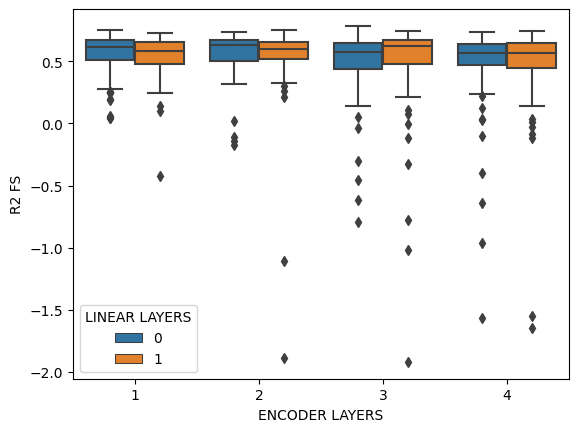

In [18]:
sns.boxplot(data=data, x='ENCODER LAYERS', y='R2 FS', hue='LINEAR LAYERS')

<Axes: xlabel='MEMORY', ylabel='R2 FS'>

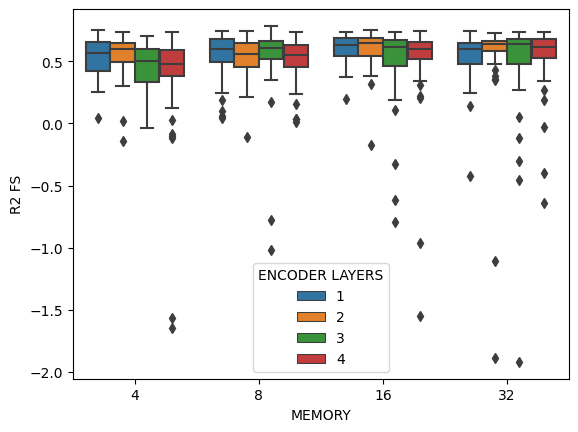

In [28]:
sns.boxplot(data=data, x='MEMORY', y='R2 FS', hue='ENCODER LAYERS')

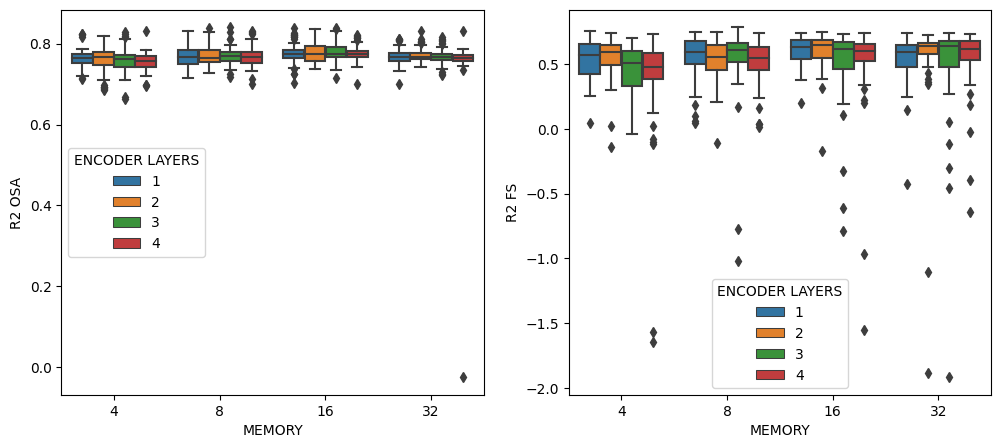

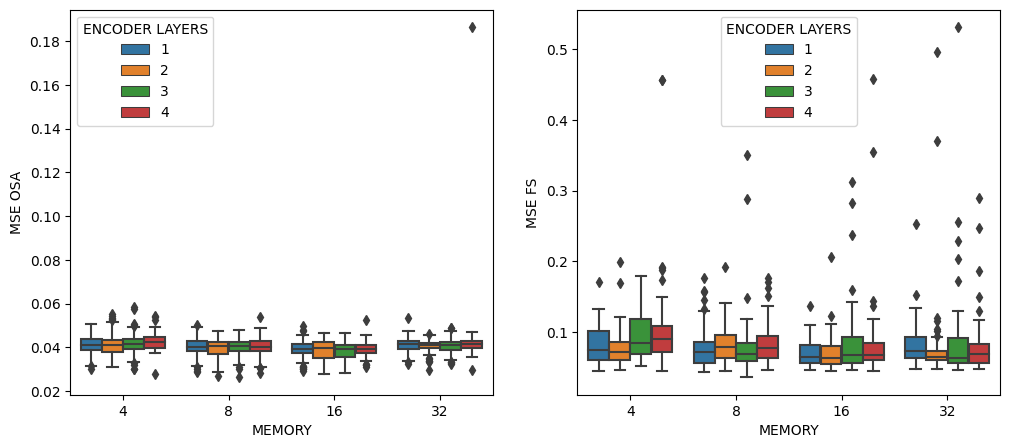

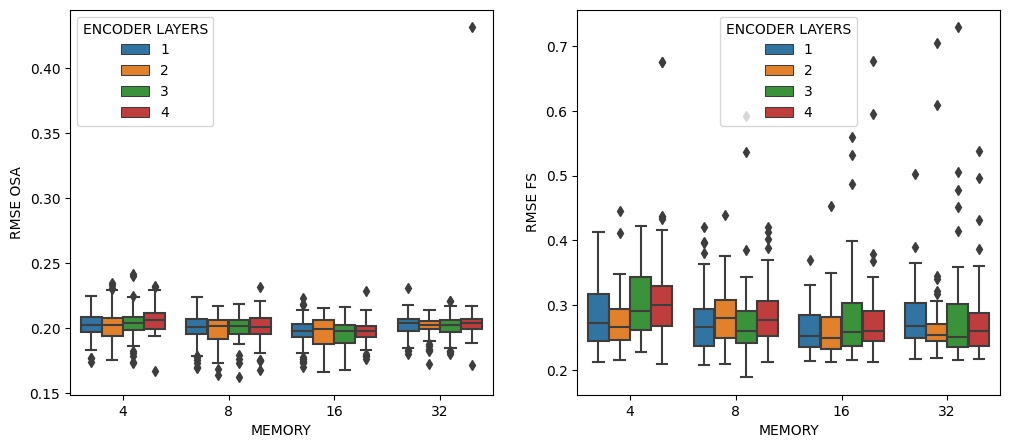

In [56]:
x_axis = 'MEMORY'
metrics = ['R2', 'MSE', 'RMSE']
hue = 'ENCODER LAYERS'

for y_axis in metrics:
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sns.boxplot(data=data, x=x_axis, y=f'{y_axis} OSA', hue=hue, ax = ax[0])
    #sns.lineplot(data=data, x=x_axis, y=f'{y_axis} OSA', ax = ax[0])
    sns.boxplot(data=data, x=x_axis, y=f'{y_axis} FS', hue=hue, ax = ax[1])
    #sns.lineplot(data=data, x=x_axis, y=f'{y_axis} FS', ax = ax[1])
    fig.savefig(f'latex/images/boxplot_{x_axis}_{y_axis}_{hue}.pdf')
    

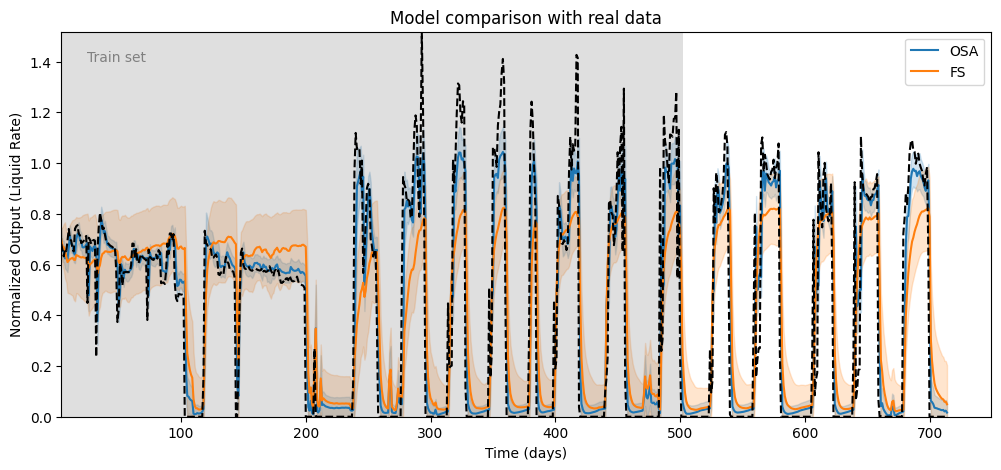

In [82]:
ts_data = {
    'INDEX':[],
    'OSA':[],
    'FS' :[],
}

y_real = None
index_real = None

for index, row in data.iterrows():
    osa = row['PREDICTED OSA']
    fs = row['PREDICTED FS']
    if y_real is None:
        y_real = row['TRUE']
    memory = int(row['MEMORY'])
    index = [memory + i for i in range(osa.shape[0])]
    if index_real is None:
        index_real = index.copy()
    ts_data['INDEX'].extend(index)
    ts_data['OSA'].append(osa)
    ts_data['FS'].append(fs)
    
ts_data['OSA'] = torch.vstack(ts_data['OSA']).ravel()
ts_data['FS'] = torch.vstack(ts_data['FS']).ravel()

fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.lineplot(data=ts_data, x='INDEX', y='OSA', ax=ax, label='OSA', errorbar=('sd', 1))
sns.lineplot(data=ts_data, x='INDEX', y='FS', ax=ax, label='FS', errorbar=('sd', 1))
ax.plot(index_real, y_real, 'k--', label='REAL')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Normalized Output (Liquid Rate)')
ax.set_title('Model comparison with real data')
ax.fill_between(np.array(index_real), 0, torch.max(y_real), where = np.array(index_real)<=502,
                facecolor ='grey', alpha = 0.25)

ax.set_xlim(np.min(index_real),None)
ax.set_ylim(0,torch.max(y_real))
ax.text(25, 1.4, 'Train set', color='grey')

fig.savefig(f'latex/images/prediction_errorbars.pdf')

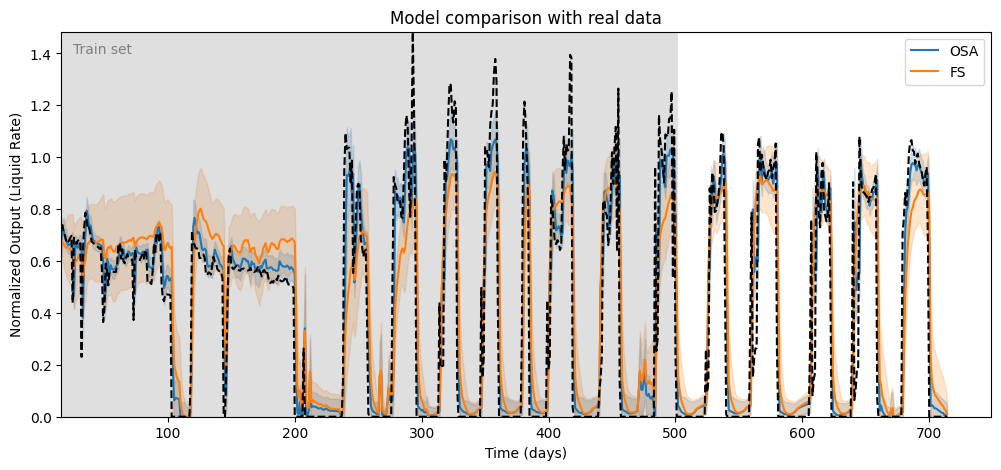

In [83]:
ts_data = {
    'INDEX':[],
    'OSA':[],
    'FS' :[],
}

y_real = None
index_real = None

for index, row in data[(data['ENCODER LAYERS']==1)&(data['LINEAR LAYERS']==0)&(data['MEMORY']=='16')].iterrows():
    osa = row['PREDICTED OSA']
    fs = row['PREDICTED FS']
    if y_real is None:
        y_real = row['TRUE']
    memory = int(row['MEMORY'])
    index = [memory + i for i in range(osa.shape[0])]
    if index_real is None:
        index_real = index.copy()
    ts_data['INDEX'].extend(index)
    ts_data['OSA'].append(osa)
    ts_data['FS'].append(fs)
    
ts_data['OSA'] = torch.vstack(ts_data['OSA']).ravel()
ts_data['FS'] = torch.vstack(ts_data['FS']).ravel()

fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.lineplot(data=ts_data, x='INDEX', y='OSA', ax=ax, label='OSA', errorbar=('sd', 1))
sns.lineplot(data=ts_data, x='INDEX', y='FS', ax=ax, label='FS', errorbar=('sd', 1))
ax.plot(index_real, y_real, 'k--', label='REAL')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Normalized Output (Liquid Rate)')
ax.set_title('Model comparison with real data')
ax.fill_between(np.array(index_real), 0, torch.max(y_real), where = np.array(index_real)<=502,
                facecolor ='grey', alpha = 0.25)

ax.set_xlim(np.min(index_real),None)
ax.set_ylim(0,torch.max(y_real))
ax.text(25, 1.4, 'Train set', color='grey')

fig.savefig(f'latex/images/prediction_errorbars_basemodel.pdf')